In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [ ]:
#I guess do this for now?
#tf.config.run_functions_eagerly(False)

In [5]:
#load/preprocess.

POINTS1=np.float32([[215,40],[895,65],[305,810],[930,780]])
SIZE = 700
POINTS2 = np.float32([[0,0],[SIZE,0],[0,SIZE],[SIZE,SIZE]])

M = cv.getPerspectiveTransform(POINTS1,POINTS2)
#gray_mask = cv.warpPerspective(pre_gray_mask,M,(700,700))

def load_marsh_images(folder):
    images = []
    
    for i in range(1,12):
        img = cv.imread(os.path.join(folder,"Band%d.jpg" % i))
        print("Band%d.jpg" % i)
        if img is not None:
            #convert to black and white
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            #warp so the mask is square
            img = cv.warpPerspective(img,M,(SIZE,SIZE))
            images.append(img)
        
        #do same for mask
        marsh_mask = cv.imread("marsh_mask.jpg")
        marsh_mask = cv.cvtColor(marsh_mask, cv.COLOR_BGR2GRAY)
        marsh_mask = cv.warpPerspective(marsh_mask,M,(700,700))
        
    images = np.array(images)

    return images,marsh_mask
    
    #for filename in os.listdir(folder):
    #    img = cv.imread(os.path.join(folder,filename))
    #    if img is not None:
    #        images.append(img)
    #return images




In [6]:
#process marsh images 

marsh_images_gray,gray_mask = load_marsh_images("train_jpg")
#try converting to greyscale 


Band1.jpg
Band2.jpg
Band3.jpg
Band4.jpg
Band5.jpg
Band6.jpg
Band7.jpg
Band8.jpg
Band9.jpg
Band10.jpg
Band11.jpg


In [7]:
marsh_images_gray.shape

(11, 700, 700)

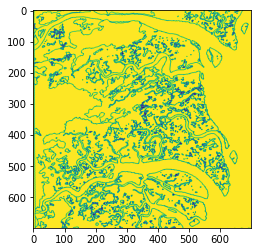

In [8]:
#convert to grayscale 
#gray_marsh = cv.cvtColor(marsh_images[7], cv.COLOR_BGR2GRAY)
#plt.imshow(gray_marsh)
plt.imshow(gray_mask)


# Preliminary attempt 

Use many crops of the images/labels as training data for u-nets. Train to guess boundary or not boundary (at first). 

Issues to be solved: 

1. The solutions need to be stiched together somehow. 
2. The solution does not automatically output a curve - the boundary can be wider than 1.
3. The solution does not know what is marsh, water, etc. A solution to this might be to instead output three classes, then compare the boundary.
4. The mask only covers part of the image and has a weird shape. Also the parallelogram is included, which it shouldn't be. I think the right thing to do is to somehow mask off what's outside the parallelogram. 
5. Can't use any pre-trained u-net out of the box because of the extra image bands - need one with enough channels.

## Extracting patches

In [9]:




def get_patches(img_list,patch_size,patch_stride,mask=False):
    
    image = tf.convert_to_tensor(img_list, dtype =tf.float32)/255.0
    
    
    if mask:
        HEIGHT,WIDTH = image.shape
        reshaped_image = tf.reshape(image,[1,HEIGHT,WIDTH,1])
    else:
        BANDS,HEIGHT,WIDTH = image.shape
        reshaped_image = tf.transpose(image, perm=[1,2,0])
        reshaped_image = tf.reshape(reshaped_image,[1,HEIGHT,WIDTH,BANDS])



    patches = tf.image.extract_patches(images=reshaped_image,
                               sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
                               strides=[1, PATCH_STRIDE, PATCH_STRIDE, 1],
                               rates=[1, 1, 1, 1],
                               padding='VALID')

    if mask:
        patches = tf.reshape(patches,[-1,PATCH_SIZE,PATCH_SIZE,1])
    else:
        patches = tf.reshape(patches,[-1,PATCH_SIZE,PATCH_SIZE,BANDS])
    
    
    return patches 



    

In [118]:
# get many crops as training data. 
#dtype=tf.float32

image = tf.convert_to_tensor(marsh_images_gray, dtype =tf.float32)/255.0

 
BANDS,HEIGHT,WIDTH = image.shape

reshaped_image = tf.transpose(image, perm=[1,2,0])



reshaped_image = tf.reshape(reshaped_image,[1,HEIGHT,WIDTH,BANDS])
#check shape 
#print(reshaped_image.shape)
#plt.imshow(reshaped_image.numpy()[0,:,:,10])

#small data set for now
PATCH_SIZE = 128
PATCH_STRIDE = 30

patches = tf.image.extract_patches(images=reshaped_image,
                           sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
                           strides=[1, PATCH_STRIDE, PATCH_STRIDE, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')


patches = tf.reshape(patches,[-1,PATCH_SIZE,PATCH_SIZE,BANDS])

#plt.imshow(patches.numpy()[24,:,:,22])


num_patches = patches.shape[0]

#same for mask 

mask_image = tf.convert_to_tensor(gray_mask, dtype =tf.float32)/255.0

reshaped_mask = tf.reshape(mask_image,[1,HEIGHT,WIDTH,1])

mask_patches = tf.image.extract_patches(images=reshaped_mask,
                           sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
                           strides=[1, PATCH_STRIDE, PATCH_STRIDE, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')


mask_patches = tf.reshape(mask_patches,[-1,PATCH_SIZE,PATCH_SIZE,1])


#plt.imshow(mask_patches.numpy()[24,:,:,0])

In [122]:
#marsh_images_gray[:,:500,:].shape
#gray_mask[:500,:].shape

(500, 700)

In [10]:
PATCH_SIZE = 128
PATCH_STRIDE = 10

patches = get_patches(marsh_images_gray[:,:500,:],PATCH_SIZE,PATCH_STRIDE)
mask_patches = get_patches(gray_mask[:500,:],PATCH_SIZE,PATCH_STRIDE,mask=True)

test_patches = get_patches(marsh_images_gray[:,500:,:],PATCH_SIZE,PATCH_STRIDE)
test_mask = get_patches(gray_mask[500:,:],PATCH_SIZE,PATCH_STRIDE,mask=True)



Metal device set to: Apple M1


2022-02-20 17:36:52.837774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-20 17:36:52.838525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(464, 128, 128, 11) (464, 128, 128, 1)
(2204, 128, 128, 11) (2204, 128, 128, 1)


<Figure size 432x288 with 0 Axes>

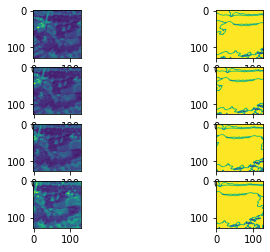

In [11]:
#make sure they line up
plt.figure()

f, axarr = plt.subplots(4,2) 

for i in range(4):
    axarr[i][0].imshow(patches.numpy()[20 + i,:,:,7])
    axarr[i][1].imshow(mask_patches.numpy()[20 + i,:,:,0])
print(test_patches.shape,test_mask.shape)
print(patches.shape,mask_patches.shape)

## Training from patches 

In [12]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output



In [13]:
mask_patches.shape

TensorShape([2204, 128, 128, 1])

In [14]:
#do a 50-50 split for now - top half of image
#TRAIN_RATIO = 2
#TRAIN_LENGTH = num_patches//TRAIN_RATIO
BATCH_SIZE = 64
BUFFER_SIZE = 100
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [15]:
#define train_images 

#I need to convert to a tensorflow dataset, I guess. 

#so right now I just have a big tensor. Need to say X_train = one part, y_train = another part.

#patches.shape

patch_dataset = tf.data.Dataset.from_tensor_slices((patches,mask_patches))

#patch_dataset

test_dataset = tf.data.Dataset.from_tensor_slices((test_patches,test_mask))

In [16]:
#batches

#try it without shuffling - this may be causing leakage

train_batches = (
    patch_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    #.repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)

# Creating the model
I used the same neural network from the tutorial but with a 1x1 convolution to change the number of channels.

In [17]:
#tried to use mobilenet with more channels, got issues.

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [18]:
# try to implement mobilenet (or something like it) myself. 
# for now just try to guess if mask/not mask?
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [19]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 11])

    #try to do a 1x1 convolution to get it down to size.
    #reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
    reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
  # Downsampling through the model
    #skips = down_stack(inputs)
    skips = down_stack(reduce_channel)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [156]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 11 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 3)  36          input_6[0][0]                    
__________________________________________________________________________________________________
model_4 (Functional)            [(None, 64, 64, 96), 1841984     conv2d_1[0][0]                   
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 8, 8, 512)    1476608     model_4[0][4]                    
____________________________________________________________________________________________

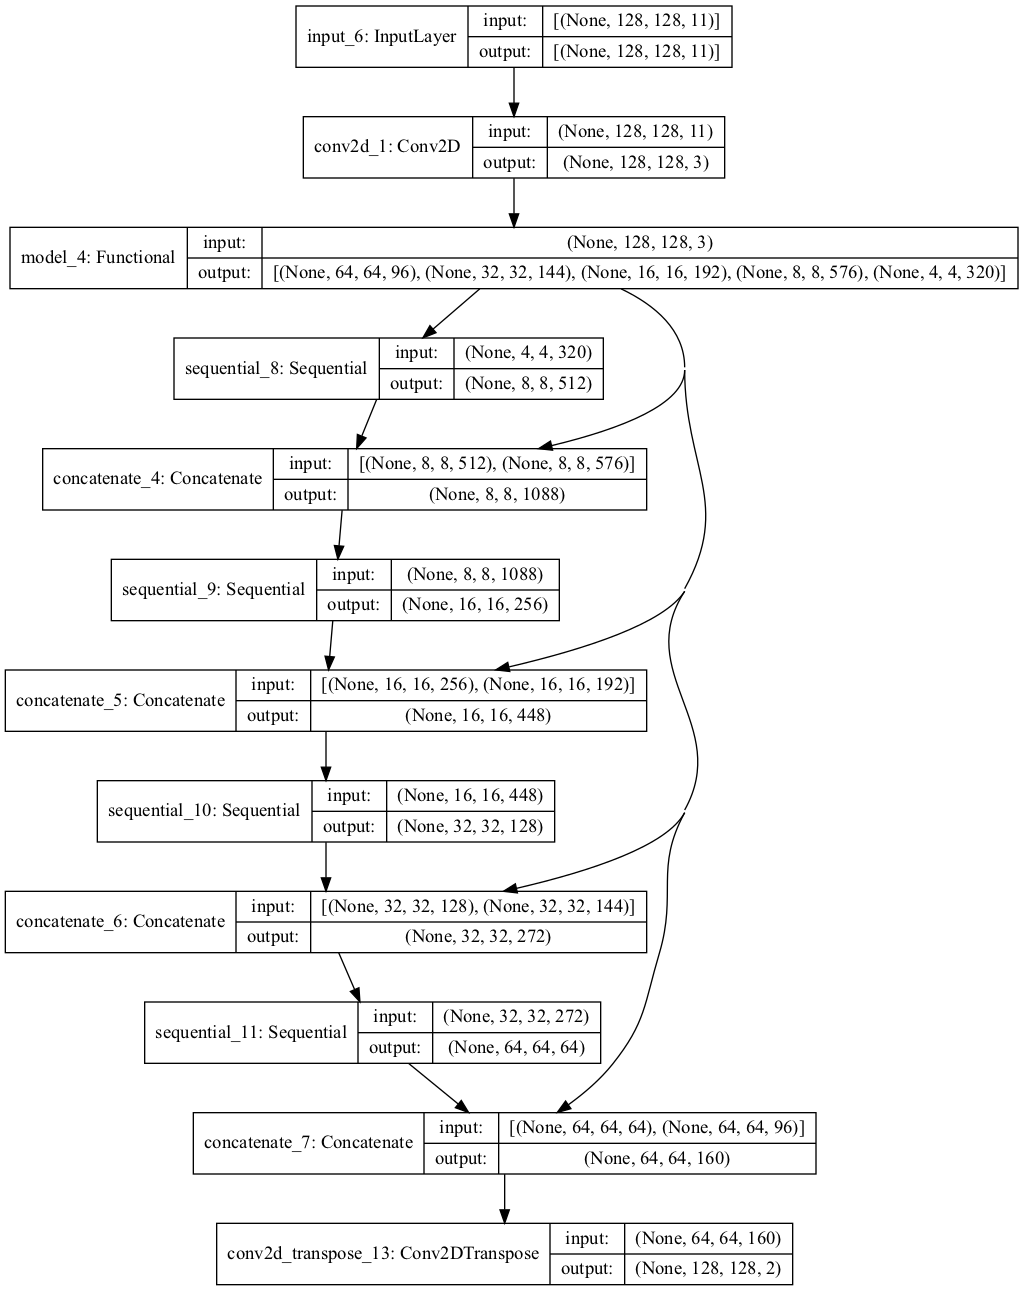

In [70]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Testing the model

Try out the model to check what it predicts before training.

In [169]:
#for images, masks in train_batches.take(2):
#  sample_image, sample_mask = images[0], masks[0]
#  display([sample_image, sample_mask])

for patch,mask in patch_dataset.skip(10).take(1):
    sample_image,sample_mask = patch, mask
#for mask in mask_dataset.take(40):
#    sample_mask = mask



In [20]:
#to show the 
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
def show_predictions_loaded(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = loaded_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(loaded_model.predict(sample_image[tf.newaxis, ...]))])
    
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i][:,:,:3]))
    plt.axis('off')
  plt.show()

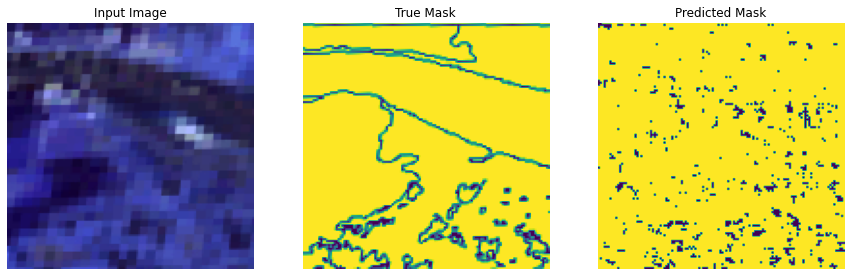

In [179]:
#im = patch[:,:,:3]
#im.shape
show_predictions()

#wow, it actually does something!!! 

# Training the model

Going to give it a shot. 

In [144]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

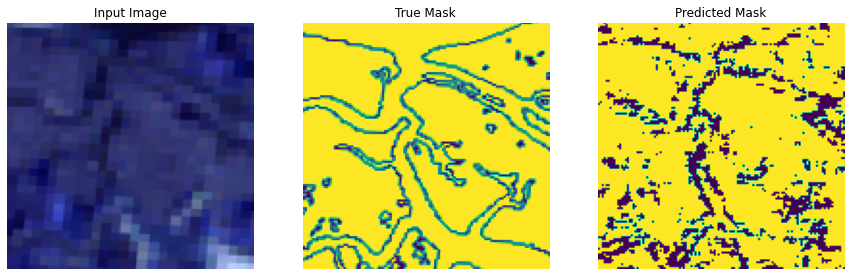


Sample Prediction after epoch 1000



In [159]:
EPOCHS = 1000
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS



model_history = model.fit(train_batches, epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()]
                         )

In [ ]:
# it does seem to be doing way better. but why is it oscillating between epochs? 
#I think we need to do something about the issue with some having masks and some not
#also we need to look at test data, not just data that's used to train 

# Save the model



In [53]:
model.save('saved-model-unweighted')

2022-02-14 20:18:28.197502: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved-model-unweighted/assets


/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [31]:
#loading model?
loaded_model = tf.keras.models.load_model('saved-model-unweighted')

2022-02-14 14:40:14.819580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


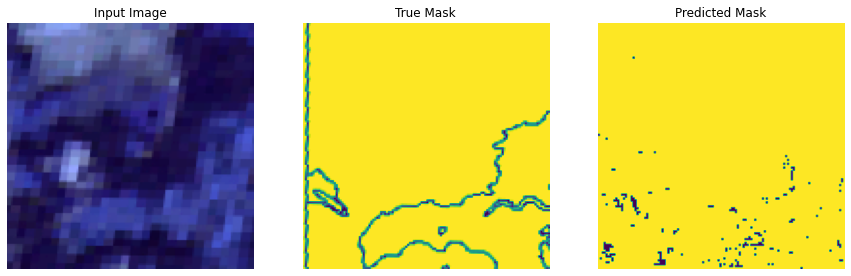

In [32]:
show_predictions_loaded()

# Weighted model

Currently broken.

2022-02-20 17:41:13.571500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


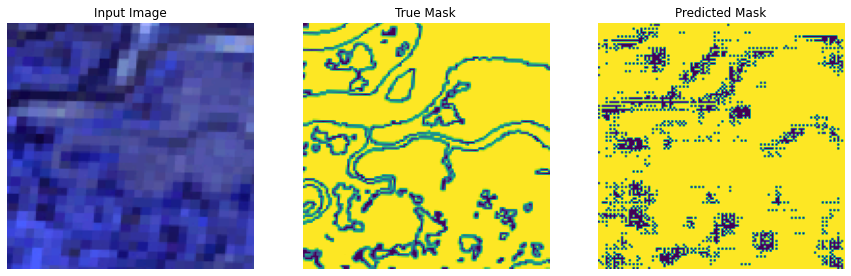

In [27]:
#first inspect
for patch,mask in test_dataset.skip(20).take(1):
    sample_image,sample_mask = patch, mask
    show_predictions_weighted()

In [21]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [78]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [23]:
OUTPUT_CLASSES = 2
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [24]:
def show_predictions_weighted(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = weighted_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(weighted_model.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback_weighted(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #if epoch % 3 == 0:
    clear_output(wait=True)
    show_predictions_weighted()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


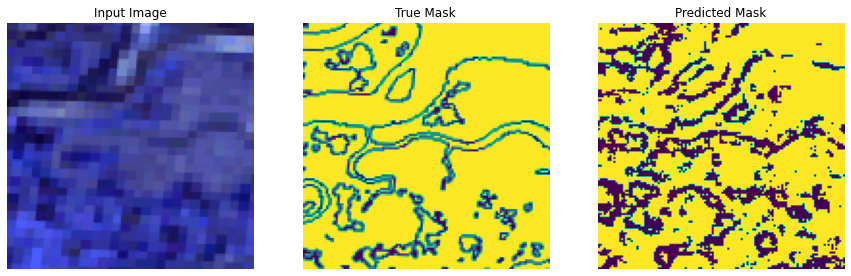


Sample Prediction after epoch 500

Epoch 501/1000
13/35 [==========>...................] - ETA: 13s - loss: 0.0547 - accuracy: 0.7997

In [ ]:
EPOCHS = 1000
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS



weighted_model_history = weighted_model.fit(train_batches.map(add_sample_weights), epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback_weighted()]
                         )

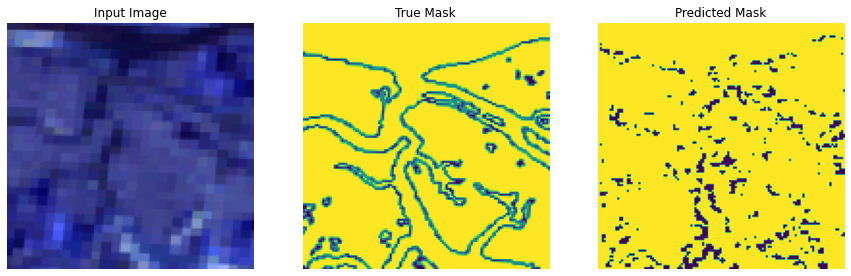

In [184]:
for patch,mask in test_dataset.skip(10).take(1):
    sample_image,sample_mask = patch, mask
    show_predictions_weighted()

In [59]:
# big question - is there data leakage?
model.save('saved-model-transformed')

2022-02-12 00:09:49.960048: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved-model-transformed/assets


/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
